What i have: a bunch of functions that takes a sentence, asks gpt-2 to complete it, repasses the full gen through the model, takes the layer activations and computes the energy of this activation.

What I want to do:
- Create a full pipeline for the process of computing energy - done
- Compare different generations in GPT-2XL but I can't ask for less coherent things
- Do a bunch of generations in GPT-2XL and compare them to GPT-2
- Upgrade to LLama-3.1-8B-IT - we can ask different generations

Additional thoughts:
- Are we computing the energy between each word? 
- Only computing dot product between activations, not really the curvate as defined by Fedorenko et. al.
- Not doing data cleaning in the end of generations (doens't stop on .) - Easy to implement

## Defining the methodology

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
model = GPT2LMHeadModel.from_pretrained("gpt2-xl", output_hidden_states=True)
model.eval()

/home/jdias/code/llama/coherence/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [9]:
#move to GPU 
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Generate completion and then run it through the model to obtain activations

In generation the model produces 1 token at a time so the sequence length is 1. We can also generate and then pass the full prompt through the model - I don't think this is what we're looking for but if first approach is not working is something to keep in mind.

In [ ]:
def generate_completion(prompt, printing=False):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    #generate continuation from the prompt
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.9,
            repetition_penalty=1.2, #without this gen is very repetitive 
            top_p=0.95,
            return_dict_in_generate=True,
            output_hidden_states=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_ids = outputs.sequences

    if printing == True:
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print("Generated text:\n", generated_text)
    
    return generated_ids

def inference_activations(gen_ids):
    #pass the full generation through the model 
    with torch.no_grad():
        full_outputs = model(
            input_ids=gen_ids,
            output_hidden_states=True,
            return_dict=True
        )

    return [layer[0] for layer in full_outputs.hidden_states] #list with pt tensor of activations in each element


In [ ]:
prompt = "A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as"
gen_ids = generate_completion(prompt, printing=True)

all_layer_activations = inference_activations(gen_ids)

In [ ]:
#The size for GPT2 in one of the activation layers: 1x9x768 - batch_size x sequence_length x hidden_size
all_layer_activations[0].shape

#### Defining energy pipeline

##### Consecutive words vector computation

In [2]:
#for a layer, take the matrix and subtract consecutive rows 
def compute_layer_vectors(layer_activation):
    return layer_activation[1:]-layer_activation[:-1]

#for all the hidden states, compute transition vectors for each layer and store them all
def compute_vectors(hidden_states):
    return [compute_layer_vectors(layer) for layer in hidden_states]

In [ ]:
vector_transitions = compute_vectors(all_layer_activations)

##### Dot product between consecutive vectors

In [3]:
def compute_dot_product_layer(layer_vectors):
    return torch.stack([torch.dot(layer_vectors[i,:],layer_vectors[i+1,:]) for i in range(layer_vectors.shape[0]-1)])

def compute_dot_product(vector_transitions_trajectory):
    return [compute_dot_product_layer(layer_vectors) for layer_vectors in vector_transitions_trajectory]    

In [ ]:
vector_dot_products = compute_dot_product(vector_transitions)

##### Dot product sum across trajectory

In [4]:
#average across layer

def average_layer_dot_product(layer_dot_product):
    return layer_dot_product.mean()

#for all layers
def average_dot_product(dot_product_list):
    return torch.stack([average_layer_dot_product(layer_dot_product) for layer_dot_product in dot_product_list])

In [ ]:
average_trajectory_dot_products = average_dot_product(vector_dot_products)

##### Compute total prompt energy 

In [5]:
#sum prompt energy through layers

def sum_layer_energy(average_layer_dot_product):
    return average_layer_dot_product.sum()

In [ ]:
sum_layer_energy(average_trajectory_dot_products)

### Energy Pipeline 

In [6]:
def energy_pipeline(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer + embedding layer).")
    return sum_layer_energy(average_dot_product(compute_dot_product(compute_vectors(layer_hidden_states)))).item()

## Energy values for different GPT-2XL generations

In [7]:
def generate_multiple_completion(prompt, repetion_value=1.2, printing=False,num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    #generate continuation from the prompt
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.9,
            repetition_penalty=repetion_value, #without this gen is very repetitive 
            top_p=0.95,
            return_dict_in_generate=True,
            output_hidden_states=False,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=num_return_sequences,
        )
    
    generated_ids = outputs.sequences

    if printing == True:
        for i, generation in enumerate(generated_ids):
            generated_text = tokenizer.decode(generation, skip_special_tokens=True)
            print(f'Generated text:\n {generated_text}\n')
    
    return generated_ids

def inference_activations(gen_ids):
    #pass the full generation through the model 
    with torch.no_grad():
        full_outputs = model(
            input_ids=gen_ids,
            output_hidden_states=True,
            return_dict=True
        )

    return [layer[0] for layer in full_outputs.hidden_states] #list with pt tensor of activations in each element


In [10]:
prompt = "A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as"
generated_ids = generate_multiple_completion(prompt,repetion_value=1.2, printing=False, num_return_sequences=5)

In [11]:
energy_values = []
for i in range(generated_ids.shape[0]):
    tensor = generated_ids[i:i+1] #shape 1xseq_length
    activations = inference_activations(tensor)
    energy_values.append(energy_pipeline(activations))

In [16]:
activations[0].shape

torch.Size([122, 1600])

### Plotting 200 prompts

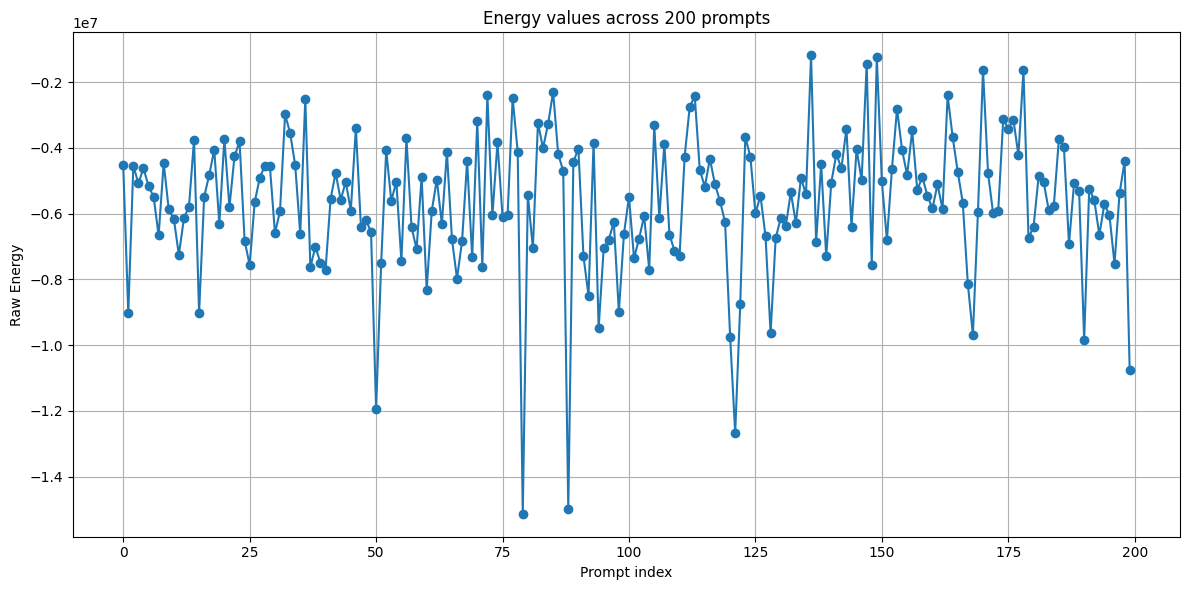

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(energy_values)), energy_values, marker='o', linestyle='-')
plt.title("Energy values across 200 prompts")
plt.xlabel("Prompt index")
plt.ylabel("Raw Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


Print maximum and minimum energy texts

In [12]:
import numpy as np 

In [30]:
max_i = np.where(energy_values==np.max(energy_values))[0]
min_i = np.where(energy_values == np.min(energy_values))[0]

In [48]:
max_energy_ids = generated_ids[int(max_i):int(max_i)+1] #has a big sequence of stop tokens in the end
min_energy_ids = generated_ids[int(min_i):int(min_i)+1]

In [46]:
max_energy_text = tokenizer.decode(max_energy_ids[0], skip_special_tokens=True) #need to remove first dimension
print(f'Maximum energy text:\n {max_energy_text}\n') 

min_energy_text = tokenizer.decode(min_energy_ids[0], skip_special_tokens=True)
print(f'Minimum energy text:\n {min_energy_text}\n')

Maximum energy text:
 A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as he took a deep breath and raised his voice into the night:

"I am Ysera who stands upon the crest of Mount Hyjal! Come and face me!"

Minimum energy text:
 A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as his eyes opened.

"You have betrayed me!" he roared at Yuria, and thrust a huge sword through her back. He fell backwards over the edge of the cliff, clutching himself to one side with blood pouring from his wound.

As soon as Yuria was sure it was dead, she took out a crystal ball from her chest pouch and turned back towards the Dragon. She could feel the magic surrounding it.

The energy coursing through the area caused a powerful surge



In [ ]:
top_5_indices = np.argsort(energy_values)[-5:]  
bottom_5_indices = np.argsort(energy_values)[:5]  #first 5 are smallest

In [54]:
print("Top 5 Maximum Energy Texts:")
for idx in reversed(top_5_indices):  # highest energy first
    ids = generated_ids[int(idx):int(idx)+1]
    text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Index {idx} — Energy: {energy_values[idx]:.4f}\n{text}\n")

Top 5 Maximum Energy Texts:
Index 136 — Energy: -1186691.1250
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as he took a deep breath and raised his voice into the night:

"I am Ysera who stands upon the crest of Mount Hyjal! Come and face me!"

Index 149 — Energy: -1239249.1250
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as he held it over his head and prepared to face the challenge that lay ahead…

Index 147 — Energy: -1449429.1250
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as he shouted out to his companions.

"We have arrived!"

Index 170 — Energy: -1640372.3750
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as he stared down at the man who dared to stand against him and his dark master…The first step of this new adventure had finally arrived…

You can check out a few more photos from h

In [55]:
print("Bottom 5 Minimum Energy Texts:")
for idx in bottom_5_indices:  # lowest energy first
    ids = generated_ids[int(idx):int(idx)+1]
    text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Index {idx} — Energy: {energy_values[idx]:.4f}\n{text}\n")

Bottom 5 Minimum Energy Texts:
Index 79 — Energy: -15126902.0000
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as his eyes opened.

"You have betrayed me!" he roared at Yuria, and thrust a huge sword through her back. He fell backwards over the edge of the cliff, clutching himself to one side with blood pouring from his wound.

As soon as Yuria was sure it was dead, she took out a crystal ball from her chest pouch and turned back towards the Dragon. She could feel the magic surrounding it.

The energy coursing through the area caused a powerful surge

Index 88 — Energy: -14989485.0000
A brave knight stood before the cave, sword drawn. The dragon's breath steamed in the cold air as she prepared to strike him down.

"I am ready. I know you are."

The dragon blinked, and raised a hand. A great blue light appeared out of nowhere, enveloping her with it. The dragon disappeared from sight into nothingness, leaving her alone once more.

"What i

#### Failed log-scale

In [ ]:
import numpy as np

energy_values = np.array(energy_values)

# Make sure all values are strictly positive
min_energy = np.min(energy_values)
if min_energy <= 0:
    shift = abs(min_energy) + 1e-5  # small epsilon to avoid log(0)
    energy_values_shifted = energy_values + shift
else:
    energy_values_shifted = energy_values

# Apply log10 scaling
log_energy_values = np.log10(energy_values_shifted)


In [ ]:
np.where(energy_values_shifted==np.min(energy_values_shifted))

In [ ]:
energy_values_shifted[190]

In [ ]:
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(range(len(log_energy_values)), log_energy_values, marker='o', linestyle='-')
plt.title("Log-scaled energy values across 200 prompts")
plt.xlabel("Prompt index")
plt.ylabel("log10(Energy)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Different prompt energy

In [ ]:
def batch_energy(prompt, num_return_sequences, repetion_value=1.2, printing=False):
    generated_ids = generate_multiple_completion(prompt, repetion_value, printing, num_return_sequences)
    energy_values = []
    for i in range(generated_ids.shape[0]):
        tensor = generated_ids[i:i+1] #shape 1xseq_length
        activations = inference_activations(tensor)
        energy_values.append(energy_pipeline(activations))

    return generated_ids, energy_values

In [ ]:
prompt1 = "In a kingdom where dragons are the last remnants of ancient magic, a young girl discovers a dragon egg buried beneath her village well. She decides to..."
gen_ids1, energy1 = batch_energy(prompt1, num_return_sequences=200, repetion_value=1.2, printing=True)

In [7]:
import json

with open("save/energy_knight.json", "r") as f:
    energy_values_1 = json.load(f)

with open("save/energy_kingdom.json", "r") as f:
    energy_values_2 = json.load(f)
    
with open("save/energy_spaceship.json", "r") as f:
    energy_values_3 = json.load(f)

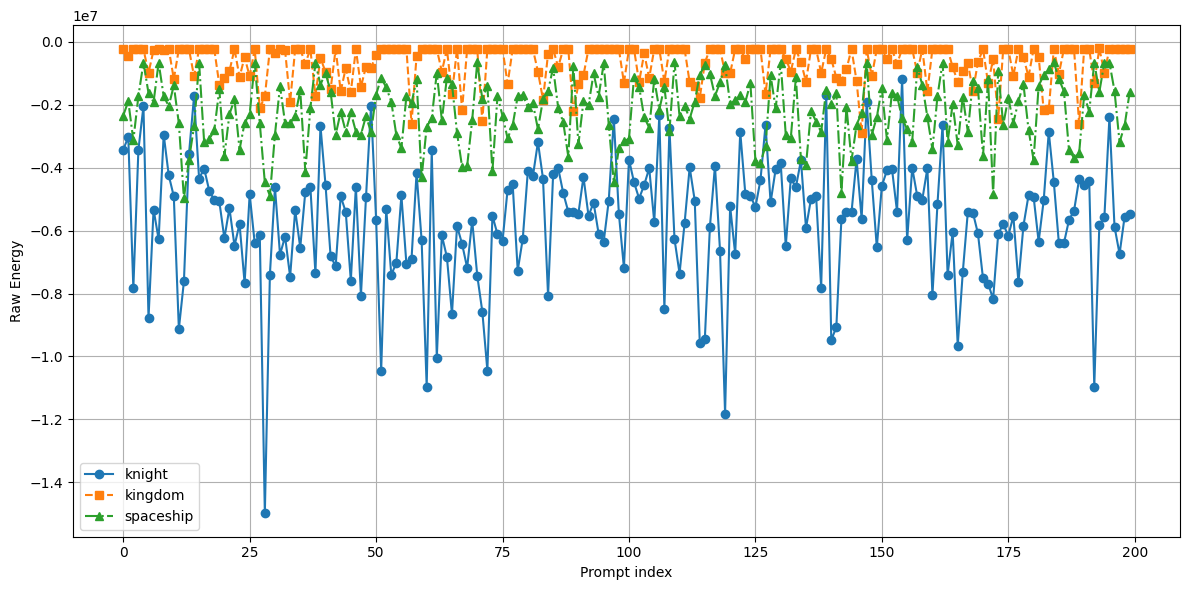

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

x1 = range(len(energy_values_1))
x2 = range(len(energy_values_2))
x3 = range(len(energy_values_3))

label1 = 'knight'
label2 = 'kingdom'
label3 = 'spaceship'

plt.plot(x1, energy_values_1, marker='o', linestyle='-', label=label1)
plt.plot(x2, energy_values_2, marker='s', linestyle='--', label=label2)
plt.plot(x3, energy_values_3, marker='^', linestyle='-.', label=label3)

plt.xlabel("Prompt index")
plt.ylabel("Raw Energy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()